# Setting tolerances
The purpose of this notebook is to highlight some of the input variables that affect the algebraic solvers. 

The notebook covers the following
- Defining a nonlinear PDE
- Defining the initial-boundary value problem
- How to choose a particular set of numerics
- How to set the solver tolerances
- How to post-process the solution
- Three example runs
  - tight tolerances that achieve quadratic  convergence in the Newton iteration
  - looselinear tolerances that reduce Newton convergnce to linear
  - very tight linear tolerances  that result in too many  linear iterations

In [1]:
%matplotlib inline
from proteus.iproteus import * 
Profiling.logLevel=7
Profiling.verbose=True

# Defining an equation
The equation we want to solve is
\begin{equation*}
m_t + \nabla \cdot \left(\mathbf{f} - \mathbf{a} \nabla u \right) = 0
\end{equation*}
where $u$ is the unknown solution and the coefficients have the specific  forms
\begin{align}
m(u) &= M u^p \\
f(u) &= \mathbf{B} u^q \\
a(u) &= \mathbf{A} \\
\phi(u) &= u^r \\
r(u) & = C u \\
\end{align}

# Proteus template equation
\begin{equation}
\mathbf{u} = \left[ u^0,u^1,\ldots,u^{nc-1} \right]
\end{equation}
\begin{equation*}
m^i_t + \nabla \cdot \left(\mathbf{f}^i - \sum_k^{nc-1} \mathbf{a}^{i,k} \nabla \phi^k(\mathbf{u}) \right) + r^i + H^i(\nabla u^i)= 0 \qquad \mbox{for } i=0,\ldots,nc-1
\end{equation*}

- $m$ is "mass"
- $\mathbf{f}$ is advection
- $\mathbf{a}$ is diffution
- $\phi$ is potential
- $H$ is Hamiltonian
- $r$ is reaction

Example: non-conservative advection
\begin{equation}
u_t + \mathbf{v} \cdot \nabla u = 0
\end{equation}

What is $m$?
What is $f$?
What is $H$?

In [2]:
class NLADR(TransportCoefficients.TC_base):
    """
    The coefficients of the linear advection-diffusion equation
    """
    def __init__(self,M,A,B,C,p,q,r):
        TransportCoefficients.TC_base.__init__(self,
                                               nc=1, #number of components
                                               variableNames=['u'],
                                               mass      = {0:{0:'nonlinear'}},
                                               advection = {0:{0:'nonlinear'}},
                                               diffusion = {0:{0:{0:'constant'}}},
                                               potential = {0:{0:'nonlinear'}},
                                               reaction  = {0:{0:'linear'}})
                                            
        self.M=M
        self.A=A
        self.B=B
        self.C=C
        self.p=p
        self.q=q
        self.r=r
    def evaluate(self,t,c):
        c[('m',0)][:]         = self.M*c[('u',0)]**self.p  
        c[('dm',0,0)][:]      = self.M*self.p*c[('u',0)]**(self.p-1)
        c[('f',0)][...,0]     = self.B[0]*c[('u',0)]**self.q
        c[('f',0)][...,1]     = self.B[1]*c[('u',0)]**self.q
        c[('df',0,0)][...,0]  = self.B[0]*self.q*c[('u',0)]**(self.q-1)
        c[('df',0,0)][...,1]  = self.B[1]*self.q*c[('u',0)]**(self.q-1)
        c[('a',0,0)][...,0,0] = self.A[0][0]
        c[('a',0,0)][...,1,1] = self.A[1][1]
        c[('phi',0)][:] = c[('u',0)]**self.r
        c[('dphi',0,0)][:] = self.r*c[('u',0)]**(self.r-1)
        c[('r',0)][:]         = self.C*c[('u',0)]  
        c[('dr',0,0)][:]      = self.C


# Physics

In [3]:
from proteus import default_p as p
#physics
p.name = "nladr_2d"
p.nd = 2; #Two dimensions
p.L=(1.0,1.0); 
p.T=1.0

p.coefficients=NLADR(M=1.0,
                    A=[[0.001,0.0],
                       [0.0,0.001]],
                    B=[2.0,1.0],
                    C=0.0,
                    p=1,
                    q=2,
                    r=2)

def getDBC(x,flag):
    if x[0] == 0.0 or x[1] == 0.0:
        return lambda x,t: 1.0
    #elif x[0] == p.L[0] or x[1] == p.L[1]:
    #    return lambda x,t: 0.0
    else:
        return None
    
p.dirichletConditions = {0:getDBC}
p.advectiveFluxBoundaryConditions = {}

def getDFBC(x,flag):
    if x[0] == p.L[0] or x[1] == p.L[1]:
        return lambda x,t: 0.0

p.diffusiveFluxBoundaryConditions = {0:{0:getDFBC}}
p.periodicDirichletConditions = None
class IC:
    def __init__(self):
        pass
    def uOfXT(self,x,t):
        if x[0] <= 0.0 or x[1] <= 0.0:
            return 1.0
        else:
            return 0.0

p.initialConditions  = {0:IC()}

# Numerics

In [4]:
from proteus import default_n as n
import proteus as pr
n.timeIntegration = pr.TimeIntegration.BackwardEuler_cfl
n.stepController = pr.StepControl.Min_dt_cfl_controller
n.runCFL=0.99
n.femSpaces = {0:pr.FemTools.C0_AffineLinearOnSimplexWithNodalBasis}
n.elementQuadrature = pr.Quadrature.SimplexGaussQuadrature(p.nd,3)
n.elementBoundaryQuadrature = pr.Quadrature.SimplexGaussQuadrature(p.nd-1,3)
n.subgridError = pr.SubgridError.AdvectionDiffusionReaction_ASGS(p.coefficients,
                                                                 p.nd,lag=False)
n.shockCapturing = pr.ShockCapturing.ResGradQuad_SC(p.coefficients,
                                                            p.nd,
                                                            shockCapturingFactor=0.75,
                                                            lag=True)
n.numericalFluxType = pr.NumericalFlux.Advection_DiagonalUpwind_Diffusion_SIPG_exterior
n.nnx=41; n.nny=41
n.tnList=[float(i)/40.0 for i in range(11)]
n.parallelPartitioningType = pr.MeshTools.MeshParallelPartitioningTypes.element
n.nLayersOfOverlapForParallel = 1
n.periodicDirichletConditions = None

#Nonlinear solver selection

In [5]:
n.multilevelNonlinearSolver = pr.NonlinearSolvers.Newton
n.maxLineSearches=0
#convergence criteria
n.maxNonlinearIts=50
n.tolFac = 0.0
n.nl_atol_res=1.0e-4

#Linear solver selection

In [6]:
n.matrix = pr.LinearAlgebraTools.SparseMatrix
n.multilevelLinearSolver = pr.LinearSolvers.KSP_petsc4py
# PETSc solver configuration
from petsc4py import PETSc
OptDB = PETSc.Options()
OptDB.setValue("ksp_type", "gmres")
OptDB.setValue("pc_type", "jacobi")
# convergence criteria
n.linearSolverConvergenceTest = 'r-true'
n.linTolFac = 0.001
n.l_atol_res = 0.001*n.nl_atol_res

# Operator Splitting

In [7]:
from proteus import default_s,default_so
so = default_so
so.name = p.name 
so.sList=[default_s]
so.tnList = n.tnList

# Initialize Numerical Solution Object

In [8]:
ns = NumericalSolution.NS_base(so,[p],[n],so.sList,opts)

[       0] Initializing NumericalSolution for nladr_2d
 System includes: 
nladr_2d

[       0] Setting Archiver(s)
[       0] Setting up MultilevelMesh
[       0] Building one multilevel mesh for all models
[       0] Generating mesh for nladr_2d
[       0] Building 41 x 41 rectangular mesh for nladr_2d
[       0] Partitioning mesh among 1 processors using partitioningType = 0
[       0] Number of Subdomain Elements Owned= 3200
[       0] Number of Subdomain Elements = 3200
[       0] Number of Subdomain Nodes Owned= 1681
[       0] Number of Subdomain Nodes = 1681
[       0] Number of Subdomain elementBoundaries Owned= 4880
[       0] Number of Subdomain elementBoundaries = 4880
[       0] Number of Subdomain Edges Owned= 4880
[       0] Number of Subdomain Edges = 4880
[       0] Finished partitioning
[       0] *** Global ***
Number of triangles  : 3200
Number of edges : 4880
Number of nodes : 1681

*** Local ***
Number of triangles  : 3200
Number of edges : 4880
Number of nodes : 1

# Calculate Solution

In [9]:
failed = ns.calculateSolution('nladr_run1')
assert(not failed)

[       0] Setting initial conditions
[       0] Setting initial conditions for nladr_2d
[       0] Setting initial conditions on model nladr_2d
[       0] Attaching models and running spin-up step if requested
[       0] Archiving initial conditions
[       0] Writing initial mesh for  model = nladr_2d
[       0] Writing initial conditions for  model = nladr_2d
[       0] Estimating initial time derivative and initializing time history for model nladr_2d
[       0] Choosing initial time step for model nladr_2d
[       0] Initializing time step on model nladr_2d to dt =  1.38357e-02
[       0] Initializing time history for model step controller
[       0] Auxiliary variable calculations for model nladr_2d
[       0] Syncing Archive
[       0] Initializing time step on system Default System to dt =  1.38357e-02
[       0] Initializing step sequence for system Default System to [(0.013835670610779945, <proteus.Transport.MultilevelTransport instance at 0x7f9285a13248>)]
[       0] Startin

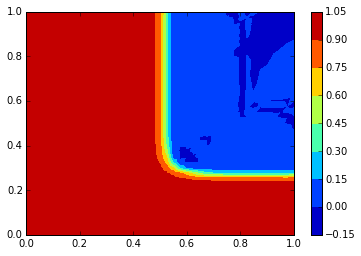

(-0.013356916211123993, 1.0000000000268345)

In [10]:
import pylab
x = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,0]
y = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,1]
triangles = ns.modelList[0].levelModelList[-1].mesh.elementNodesArray
u = ns.modelList[0].levelModelList[-1].u[0].dof
pylab.tricontourf(x,y,triangles,u)
pylab.colorbar()
pylab.show()
u.min(),u.max()

In [11]:
n.linTolFac = 0.9
ns_lin = NumericalSolution.NS_base(so,[p],[n],so.sList,opts)
failed = ns_lin.calculateSolution('nladr_lin')
assert(not failed)

[      11] Initializing NumericalSolution for nladr_2d
 System includes: 
nladr_2d

[      11] Setting Archiver(s)
[      11] Setting up MultilevelMesh
[      11] Building one multilevel mesh for all models
[      11] Generating mesh for nladr_2d
[      11] Building 41 x 41 rectangular mesh for nladr_2d
[      11] Partitioning mesh among 1 processors using partitioningType = 0
[      11] Number of Subdomain Elements Owned= 3200
[      11] Number of Subdomain Elements = 3200
[      11] Number of Subdomain Nodes Owned= 1681
[      11] Number of Subdomain Nodes = 1681
[      11] Number of Subdomain elementBoundaries Owned= 4880
[      11] Number of Subdomain elementBoundaries = 4880
[      11] Number of Subdomain Edges Owned= 4880
[      11] Number of Subdomain Edges = 4880
[      11] Finished partitioning
[      11] *** Global ***
Number of triangles  : 3200
Number of edges : 4880
Number of nodes : 1681

*** Local ***
Number of triangles  : 3200
Number of edges : 4880
Number of nodes : 1

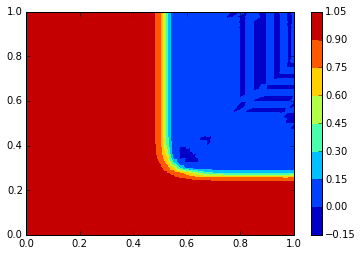

(-0.013434125684456096, 1.0000000000478406)

In [12]:
u = ns_lin.modelList[0].levelModelList[-1].u[0].dof
pylab.tricontourf(x,y,triangles,u)
pylab.colorbar()
pylab.show()
u.min(),u.max()

In [13]:
n.linTolFac = 0.0
ns_quad_over = NumericalSolution.NS_base(so,[p],[n],so.sList,opts)
failed = ns_quad_over.calculateSolution('nladr_quad_over')
assert(not failed)

[      20] Initializing NumericalSolution for nladr_2d
 System includes: 
nladr_2d

[      20] Setting Archiver(s)
[      20] Setting up MultilevelMesh
[      20] Building one multilevel mesh for all models
[      20] Generating mesh for nladr_2d
[      20] Building 41 x 41 rectangular mesh for nladr_2d
[      20] Partitioning mesh among 1 processors using partitioningType = 0
[      20] Number of Subdomain Elements Owned= 3200
[      20] Number of Subdomain Elements = 3200
[      20] Number of Subdomain Nodes Owned= 1681
[      20] Number of Subdomain Nodes = 1681
[      20] Number of Subdomain elementBoundaries Owned= 4880
[      20] Number of Subdomain elementBoundaries = 4880
[      20] Number of Subdomain Edges Owned= 4880
[      20] Number of Subdomain Edges = 4880
[      20] Finished partitioning
[      20] *** Global ***
Number of triangles  : 3200
Number of edges : 4880
Number of nodes : 1681

*** Local ***
Number of triangles  : 3200
Number of edges : 4880
Number of nodes : 1

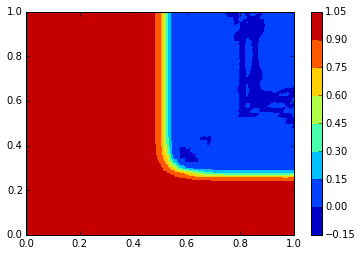

(-0.013357303492467946, 1.0000000000241953)

In [14]:
u = ns_quad_over.modelList[0].levelModelList[-1].u[0].dof
pylab.tricontourf(x,y,triangles,u)
pylab.colorbar()
pylab.show()
u.min(),u.max()